## Find the data

We are to transfer 8 patients who've been completely processed.  Let's start by listing from the `participants.csv` BIDS index file, and collecting the first 8 whose ready flags are all true.

In [ ]:
n_ready = 0
pid_ready = []
with open('epinov/participants.tsv', 'r') as fd:
    header = fd.readline()
    for line in fd.readlines():
        parts = line.strip().split()
        pid = parts[0]
        ready = all([_.lower()=='true' for _ in parts[-7:]])
        if ready:
            n_ready += 1
            pid_ready.append(pid)
            if n_ready == 8:
                break

pid_ready

['4d5ab1139afc',
 'acda1a7a0c9c',
 'dd626d19234c',
 '56d98746ac85',
 'b0d927b4502d',
 'd480db186d19',
 '0ea47a652d48',
 '3842a81ac98b']

Only a subset have approved clinical reports,

In [ ]:
pid_ok = [
    "acda1a7a0c9c",
    "56d98746ac85",
    "d480db186d19",
    "3842a81ac98b"
]

We need the following elements,

-	T1 MRI image: stored in Nifti file, anonymized, and with the skull already extracted 
-	DWI MRI image: stored in Nifti file, anonymized.
-	Diffusion gradients: two text files, named bvals.txt and bvecs.txt
-	SEEG signals: stored in an Elekta Neuromag FIFF (.fif) file, anonymized.
-	Electrodes positions : a text file named XXXXXX
-	Clinical Report: a pdf file


In [ ]:
import glob, os, tqdm, concurrent.futures, subprocess, nibabel

def find(pid, folder, pattern):
    path = os.path.join('epinov', f'sub-{pid}', 'ses-01', folder, pattern)
    return glob.glob(path)

for i, pid in enumerate(pid_ready):
    t1, = find(pid, 'anat', '*_T1w.nii')
    dwi, = find(pid, 'dwi', '*64dir_dir-AP*.nii')
    bvec, = find(pid, 'dwi', '*AP*bvec*')
    bval, = find(pid, 'dwi', '*AP*bval*')
    sxyz, = find(pid, 'ieeg', '*CT_electrodes.tsv')
    vhdrs = find(pid, 'ieeg', '*.vhdr')
    print(t1)
    print(dwi)
    print(bvec)
    print(bval)
    break

epinov/sub-4d5ab1139afc/ses-01/anat/sub-4d5ab1139afc_ses-01_acq-preop_T1w.nii
epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.nii
epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.bvec
epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.bval


In [ ]:
!ls epinov/derivatives/

clinical_report  EI	   GARDEL  log_old  parsing_old
dwi_maps	 Epitools  log	   parsing  problems-freesurfer


Well, to get started let's run FS

In [ ]:
!mkdir ~/epinov-data-xfer
!chmod 700 ~/epinov-data-xfer

In [ ]:
%%file epinov-data-xfer/run-fs.sh
#!/bin/bash
export SUBJECTS_DIR=/home/duke/epinov-data-xfer
export FREESURFER_HOME=/soft/freesurfer-6
. $FREESURFER_HOME/SetUpFreeSurfer.sh
recon-all $@

Writing epinov-data-xfer/run-fs.sh


In [ ]:
import subprocess

procs = []
for i, pid in enumerate(pid_ready):
    cmd = f"bash epinov-data-xfer/run-fs.sh -s {pid} -i {find(pid, 'anat', '*_T1w.nii')[0]} -autorecon1".split()
    print(cmd)
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    procs.append(proc)

['bash', 'epinov-data-xfer/run-fs.sh', '-s', '4d5ab1139afc', '-i', 'epinov/sub-4d5ab1139afc/ses-01/anat/sub-4d5ab1139afc_ses-01_acq-preop_T1w.nii', '-autorecon1']
['bash', 'epinov-data-xfer/run-fs.sh', '-s', 'acda1a7a0c9c', '-i', 'epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii', '-autorecon1']
['bash', 'epinov-data-xfer/run-fs.sh', '-s', 'dd626d19234c', '-i', 'epinov/sub-dd626d19234c/ses-01/anat/sub-dd626d19234c_ses-01_acq-preop_T1w.nii', '-autorecon1']
['bash', 'epinov-data-xfer/run-fs.sh', '-s', '56d98746ac85', '-i', 'epinov/sub-56d98746ac85/ses-01/anat/sub-56d98746ac85_ses-01_acq-preop_T1w.nii', '-autorecon1']
['bash', 'epinov-data-xfer/run-fs.sh', '-s', 'b0d927b4502d', '-i', 'epinov/sub-b0d927b4502d/ses-01/anat/sub-b0d927b4502d_ses-01_acq-preop_T1w.nii', '-autorecon1']
['bash', 'epinov-data-xfer/run-fs.sh', '-s', 'd480db186d19', '-i', 'epinov/sub-d480db186d19/ses-01/anat/sub-d480db186d19_ses-01_acq-preop_T1w.nii', '-autorecon1']
['bash', 'epinov-data-

In [ ]:
while True:
    done = []
    for i, (pid, proc) in enumerate(zip(pid_ready, procs)):
        try:
            proc.wait(1)
            # print(pid, 'finished with', proc.wait(0.1))
            done.append(True)
        except subprocess.TimeoutExpired:
            # print(pid, 'not done')
            done.append(False)
    if all(done):
        break

In [ ]:
!ls -lh epinov-data-xfer/*/mri/brainmask.mgz

-rw-rw-r-- 1 duke bdi 1.2M Mar 27 16:48 epinov-data-xfer/0ea47a652d48/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 1.4M Mar 27 16:47 epinov-data-xfer/3842a81ac98b/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 1.2M Mar 27 16:50 epinov-data-xfer/4d5ab1139afc/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 976K Mar 27 16:53 epinov-data-xfer/56d98746ac85/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 1.2M Mar 27 16:54 epinov-data-xfer/acda1a7a0c9c/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 1.2M Mar 27 16:52 epinov-data-xfer/b0d927b4502d/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 1.4M Mar 27 16:47 epinov-data-xfer/d480db186d19/mri/brainmask.mgz
-rw-rw-r-- 1 duke bdi 1.1M Mar 27 16:51 epinov-data-xfer/dd626d19234c/mri/brainmask.mgz


In [ ]:
!ls -lh epinov-data-xfer/*/mri/T1.mgz

-rw-rw-r-- 1 duke bdi 4.9M Mar 27 16:34 epinov-data-xfer/0ea47a652d48/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 3.9M Mar 27 16:34 epinov-data-xfer/3842a81ac98b/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 4.0M Mar 27 16:34 epinov-data-xfer/4d5ab1139afc/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 4.7M Mar 27 16:34 epinov-data-xfer/56d98746ac85/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 4.1M Mar 27 16:34 epinov-data-xfer/acda1a7a0c9c/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 4.2M Mar 27 16:34 epinov-data-xfer/b0d927b4502d/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 4.2M Mar 27 16:34 epinov-data-xfer/d480db186d19/mri/T1.mgz
-rw-rw-r-- 1 duke bdi 4.2M Mar 27 16:34 epinov-data-xfer/dd626d19234c/mri/T1.mgz


In [ ]:
!pip install --user nibabel

     |████████████████████████████████| 3.3 MB 805 kB/s eta 0:00:01     |████████████▉                   | 1.3 MB 805 kB/s eta 0:00:03
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import nibabel

In [ ]:
t1 = nibabel.load("epinov-data-xfer/0ea47a652d48/mri/T1.mgz").get_data()
mask = nibabel.load("epinov-data-xfer/0ea47a652d48/mri/brainmask.mgz").get_data()

<ipython-input-8-b41d41dadee1>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  t1 = nibabel.load("epinov-data-xfer/0ea47a652d48/mri/T1.mgz").get_data()
<ipython-input-8-b41d41dadee1>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nibabel.load("epinov-data-xfer/0ea47a652d48/mri/brainmask.mgz").get_data()


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


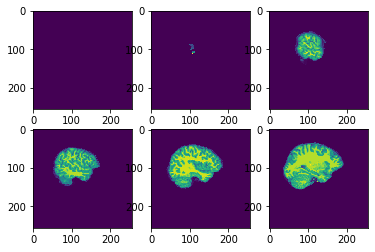

In [ ]:
for i, s in enumerate([50, 60, 70, 80, 90, 100]):
    subplot(2, 3, i + 1)
    imshow(mask[s])

So now we have the brainmasks.  We need to register the DWI & CT images, and move the mask to those coord sys.  We need to ensure the sEEG coordinates are correct at well,

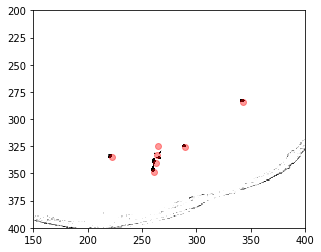

In [ ]:
xyz_path, = !ls epinov/sub-0ea47a652d48/ses-01/ieeg/*elec*.tsv
xyz = np.loadtxt(xyz_path, skiprows=1, usecols=(1, 2, 3))
x,y,z = xyz.T

ct_nii = nibabel.load("epinov/sub-0ea47a652d48/ses-01/anat/sub-0ea47a652d48_ses-01_acq-postimp_CT.nii")
ct = ct_nii.get_fdata()

sl = 170
imshow(ct[..., sl], vmin=1500, vmax=2000, cmap="binary")
zm = (z > (sl - 2)) * (z < (sl + 2))
plot(y[zm], x[zm], "ro", alpha=0.4)
axis([150, 400, 400, 200]);

Gotcha!  So the TSV file has the CT voxel indices.

## Registering images

We need to move the brain mask to original data space, both for T1 & DWI.  We also need to translate the CT voxel coordinates to original T1 space.

- register FS T1.mgz to input T1
- move FS brainmask to input T1 space
- apply brainmask to input T1
- register FS T1.mgz to input DWI
- move FS brainmask to input DWI space
- apply brainmask to input DWI
- register FS T1.mgz to input CT
- move CT voxel coordinates for sensors to input T1 space

Calling FSL and FS utilities requires boring environment setup, so I made a utility module to do this:

In [ ]:
import epinov_util as eu, subprocess, os, importlib; importlib.reload(eu);

## T1

Here's the images used for registration

In [ ]:
orig_t1_fn = "epinov/sub-0ea47a652d48/ses-01/anat/sub-0ea47a652d48_ses-01_acq-preop_T1w.nii"
fs_t1_fn = "epinov-data-xfer/0ea47a652d48/mri/T1.mgz"

the working directory and temp file names,

In [ ]:
wd = 'epinov-data-xfer/0ea47a652d48/mri'
fs_t1_ras_fn = f'{wd}/t1.fs.ras.nii.gz'
fs_t1_ras_ro_fn = f'{wd}/t1.fs.ras.ro.nii.gz'
orig_t1_ras_fn = f'{wd}/t1.orig.ras.nii.gz'
orig_t1_ras_ro_fn = f'{wd}/t1.orig.ras.ro.nii.gz'

now prep the images,

In [ ]:
eu.fs('mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', orig_t1_fn, orig_t1_ras_fn)
eu.fsl('fslreorient2std', orig_t1_ras_fn, orig_t1_ras_ro_fn)
eu.fs('mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', fs_t1_fn, fs_t1_ras_fn)
eu.fsl('fslreorient2std', fs_t1_ras_fn, fs_t1_ras_ro_fn)

finally, run flirt,

In [ ]:
flirt_opts = [
    '-verbose', 0,
    '-cost', 'mutualinfo',
    '-dof', 12,
    '-searchrz', -180, 180,
    '-searchry', -180, 180,
    '-searchrx', -180, 180,
]

aff_fn = f'{wd}/fs2orig.mat'

eu.fsl('flirt',
       '-ref', orig_t1_ras_ro_fn,
       '-in', fs_t1_ras_ro_fn,
       '-omat', aff_fn,
       *flirt_opts
      )

now use the affine matrix to move the brain mask: first reformat the brainmask,

In [ ]:
fs_bm_fn = f'{wd}/brainmask.mgz'
fs_bm_ras_fn = f'{wd}/t1.fs.ras.nii.gz'
fs_bm_ras_ro_fn = f'{wd}/t1.fs.ras.ro.nii.gz'

eu.fs('mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', fs_bm_fn, fs_bm_ras_fn)
eu.fsl('fslreorient2std', fs_bm_ras_fn, fs_bm_ras_ro_fn)

['/soft/freesurfer-6/bin/mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', 'epinov-data-xfer/0ea47a652d48/mri/brainmask.mgz', 'epinov-data-xfer/0ea47a652d48/mri/t1.fs.ras.nii.gz']
mri_convert.bin -rt nearest --out_orientation RAS epinov-data-xfer/0ea47a652d48/mri/brainmask.mgz epinov-data-xfer/0ea47a652d48/mri/t1.fs.ras.nii.gz 
$Id: mri_convert.c,v 1.226 2016/02/26 16:15:24 mreuter Exp $
reading from epinov-data-xfer/0ea47a652d48/mri/brainmask.mgz...
TR=2300.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, -1.5487e-10, 0)
j_ras = (0, 3.63798e-12, -1)
k_ras = (1.5487e-10, 1, 0)
Setting output orientation to RAS
Reslicing using nearest 
writing to epinov-data-xfer/0ea47a652d48/mri/t1.fs.ras.nii.gz...

['/soft/fsl/bin/fslreorient2std', 'epinov-data-xfer/0ea47a652d48/mri/t1.fs.ras.nii.gz', 'epinov-data-xfer/0ea47a652d48/mri/t1.fs.ras.ro.nii.gz']



then apply the transform,

In [ ]:
fs_bm_in_orig_fn = f'{wd}/bm_in_orig.nii.gz'

eu.fsl('flirt', '-applyxfm', 
       '-in', fs_bm_ras_ro_fn,
       '-ref', orig_t1_ras_ro_fn,
       '-init', aff_fn,
       '-out', fs_bm_in_orig_fn
      )

['/soft/fsl/bin/flirt', '-applyxfm', '-in', 'epinov-data-xfer/0ea47a652d48/mri/t1.fs.ras.ro.nii.gz', '-ref', 'epinov-data-xfer/0ea47a652d48/mri/t1.orig.ras.ro.nii.gz', '-init', 'epinov-data-xfer/0ea47a652d48/mri/fs2orig.mat', '-out', 'epinov-data-xfer/0ea47a652d48/mri/bm_in_orig.nii.gz']



We can check the two line up,

<matplotlib.image.AxesImage>

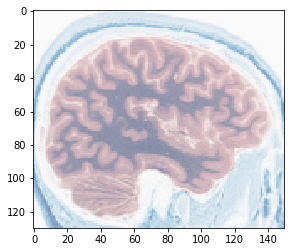

In [ ]:
bm_in_orig = nibabel.load(fs_bm_in_orig_fn).get_fdata()
orig = nibabel.load(orig_t1_ras_ro_fn).get_fdata()

imshow(bm_in_orig[120,40:190,100:230].T[::-1], 'Reds', alpha=0.5)
imshow(orig[120,40:190,100:230].T[::-1],'Blues',  alpha=0.5)

so applying the mask here is easy,

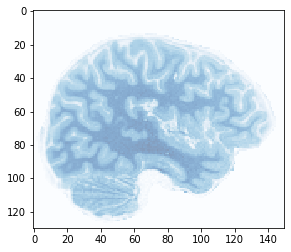

In [ ]:
mask_orig = orig * (bm_in_orig > 0)
imshow(mask_orig[120,40:190,100:230].T[::-1],'Blues',  alpha=0.5);

In [ ]:
orig_img = nibabel.load(orig_t1_ras_ro_fn)
mask_orig_img = nibabel.nifti1.Nifti1Image(
    orig_img.get_fdata() * (bm_in_orig > 0),
    orig_img.affine
)

mask_orig_fn = f'{wd}/mask_orig.nii.gz'
nibabel.save(mask_orig_img, mask_orig_fn)

To do the others, would be good to put it all into a single function,

In [ ]:
def ras_ro(img_fn, wd=None):
    wo_ext = img_fn.split('.mgz')[0].split('.nii.gz')[0]
    if wd is not None:
        wo_ext = os.path.join(wd, os.path.basename(wo_ext))
    ras_fn = wo_ext + '.ras.nii.gz'
    ras_ro_fn = wo_ext + '.ras.ro.nii.gz'
    eu.fs('mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', img_fn, ras_fn)
    eu.fsl('fslreorient2std', ras_fn, ras_ro_fn)
    return ras_ro_fn

def mask_original(pid):
    orig_t1_fn = f"epinov/sub-{pid}/ses-01/anat/sub-{pid}_ses-01_acq-preop_T1w.nii"
    fs_t1_fn = f"epinov-data-xfer/{pid}/mri/T1.mgz"
    # work files
    wd = f'epinov-data-xfer/{pid}/mri'
    fs_bm_fn = f'{wd}/brainmask.mgz'
    fs_bm_in_orig_fn = f'{wd}/bm_in_orig.nii.gz'
    mask_orig_fn = f'{wd}/mask_orig.nii.gz'
    aff_fn = f'{wd}/fs2orig.mat'
    # format images
    orig_t1_ras_ro_fn = ras_ro(orig_t1_fn)
    fs_t1_ras_ro_fn = ras_ro(fs_t1_fn)
    fs_bm_ras_ro_fn = ras_ro(fs_bm_fn)
    # register images
    eu.fsl('flirt',
           '-ref', orig_t1_ras_ro_fn,
           '-in', fs_t1_ras_ro_fn,
           '-omat', aff_fn,
           '-cost', 'mutualinfo',
           '-dof', 12,
           '-searchrz', -180, 180,
           '-searchry', -180, 180,
           '-searchrx', -180, 180,
          )
    # move mask to original space
    eu.fsl('flirt', '-applyxfm', 
           '-in', fs_bm_ras_ro_fn,
           '-ref', orig_t1_ras_ro_fn,
           '-init', aff_fn,
           '-out', fs_bm_in_orig_fn
          )
    # apply mask to original image
    bm_in_orig = nibabel.load(fs_bm_in_orig_fn).get_fdata()
    orig_img = nibabel.load(orig_t1_ras_ro_fn)
    mask_orig_img = nibabel.nifti1.Nifti1Image(
        orig_img.get_fdata() * (bm_in_orig > 0),
        orig_img.affine
    )
    nibabel.save(mask_orig_img, mask_orig_fn)

In [ ]:
mask_original("acda1a7a0c9c")

['/soft/freesurfer-6/bin/mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', 'epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii', 'epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii.ras.nii.gz']
mri_convert.bin -rt nearest --out_orientation RAS epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii.ras.nii.gz 
$Id: mri_convert.c,v 1.226 2016/02/26 16:15:24 mreuter Exp $
reading from epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii...
TR=2300.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (0.994381, -0.10278, -0.0253428)
j_ras = (0.102813, 0.994701, 1.16008e-08)
k_ras = (0.0252085, -0.00260557, 0.999679)
Setting output orientation to RAS
Reslicing using nearest 
writing to epinov/sub-acda1a7a0c9c/ses-01/anat/sub-acda1a7a0c9c_ses-01_acq-preop_T1w.nii.ras.nii.gz...

['/soft/fsl/bin/fslreorient2std', 

KeyboardInterrupt: 

## DWI

Now we need similar for the DWI.  First we'll need the get the b0 volume,

In [ ]:
in_dwi_fn = 'epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.nii'
bvec = 'epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.bvec'
bval = 'epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.bval'
wd = 'epinov-data-xfer/4d5ab1139afc/dwi'
os.path.exists(wd) or os.mkdir(wd)
dwi_fn = f'{wd}/dwi.mif'
eu.mrt_bin('mrconvert', '-fslgrad', bvec, bval, in_dwi_fn, dwi_fn)

['/soft/mrtrix3-0.3.16/release/bin/mrconvert', '-fslgrad', 'epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.bvec', 'epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.bval', 'epinov/sub-4d5ab1139afc/ses-01/dwi/sub-4d5ab1139afc_ses-01_acq-64dir_dir-AP_run-01_dwi.nii', 'epinov-data-xfer/4d5ab1139afc/dwi/dwi.mif']
mrconvert: [100%] copying from "epinov/sub...64dir_dir-AP_run-01_dwi.nii" to "epinov-dat...er/4d5ab1139afc/dwi/dwi.mif"



In [ ]:
b0_fn = f'{wd}/b0.nii.gz'
eu.mrt_bin('dwiextract', '-force', '-bzero', dwi_fn, b0_fn)

['/soft/mrtrix3-0.3.16/release/bin/dwiextract', '-force', '-bzero', 'epinov-data-xfer/4d5ab1139afc/dwi/dwi.mif', 'epinov-data-xfer/4d5ab1139afc/dwi/b0.nii.gz']
dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] extracting volumes
dwiextract: [100%] compressing image "epinov-data-xfer/4d5ab1139afc/dwi/b0.nii.gz"



Now, a similar process as for the T1, 

In [ ]:
pid = "4d5ab1139afc"
fs_t1_fn = f"epinov-data-xfer/{pid}/mri/T1.mgz"
# work files
fs_bm_fn = f'epinov-data-xfer/{pid}/mri/brainmask.mgz'
fs_bm_in_orig_fn = f'{wd}/bm_in_orig.nii.gz'
mask_orig_fn = f'{wd}/mask_orig.nii.gz'
aff_fn = f'{wd}/fs2orig.mat'
# format images
orig_b0_ras_ro_fn = ras_ro(b0_fn)
fs_t1_ras_ro_fn = ras_ro(fs_t1_fn)
fs_bm_ras_ro_fn = ras_ro(fs_bm_fn)
# register images
eu.fsl('flirt',
       '-ref', orig_b0_ras_ro_fn,
       '-in', fs_t1_ras_ro_fn,
       '-omat', aff_fn,
       '-cost', 'mutualinfo',
       '-dof', 12,
       '-searchrz', -180, 180,
       '-searchry', -180, 180,
       '-searchrx', -180, 180,
      )
# move mask to original space
eu.fsl('flirt', '-applyxfm', 
       '-in', fs_bm_ras_ro_fn,
       '-ref', orig_b0_ras_ro_fn,
       '-init', aff_fn,
       '-out', fs_bm_in_orig_fn
      )
# apply mask to original image
bm_in_orig = nibabel.load(fs_bm_in_orig_fn).get_fdata()
orig_img = nibabel.load(orig_b0_ras_ro_fn)
mask_orig_img = nibabel.nifti1.Nifti1Image(
    orig_img.get_fdata() * (bm_in_orig > 0),
    orig_img.affine
)
nibabel.save(mask_orig_img, mask_orig_fn)

['/soft/freesurfer-6/bin/mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', 'epinov-data-xfer/4d5ab1139afc/dwi/b0.nii.gz', 'epinov-data-xfer/4d5ab1139afc/dwi/b0.ras.nii.gz']
mri_convert.bin -rt nearest --out_orientation RAS epinov-data-xfer/4d5ab1139afc/dwi/b0.nii.gz epinov-data-xfer/4d5ab1139afc/dwi/b0.ras.nii.gz 
$Id: mri_convert.c,v 1.226 2016/02/26 16:15:24 mreuter Exp $
reading from epinov-data-xfer/4d5ab1139afc/dwi/b0.nii.gz...
TR=10000.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (0.999732, -0.000256536, 0.0231407)
j_ras = (3.33652e-08, 0.999939, 0.0110838)
k_ras = (-0.0231421, -0.0110808, 0.999671)
Setting output orientation to RAS
Reslicing using nearest 
writing to epinov-data-xfer/4d5ab1139afc/dwi/b0.ras.nii.gz...

['/soft/fsl/bin/fslreorient2std', 'epinov-data-xfer/4d5ab1139afc/dwi/b0.ras.nii.gz', 'epinov-data-xfer/4d5ab1139afc/dwi/b0.ras.ro.nii.gz']

['/soft/freesurfer-6/bin/mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', 'epinov-data-xfer/4d5ab1139af

<matplotlib.image.AxesImage>

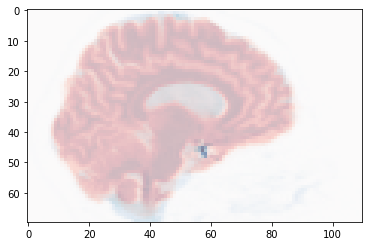

In [ ]:
imshow(bm_in_orig[50].T[::-1], 'Reds', alpha=0.5)
imshow(orig_img.get_fdata()[50].T[::-1],'Blues',  alpha=0.5)

In [ ]:
eu.mrt_bin('mrinfo', mask_orig_fn)

['/soft/mrtrix3-0.3.16/release/bin/mrinfo', 'epinov-data-xfer/4d5ab1139afc/dwi/mask_orig.nii.gz']
************************************************
Image:               "epinov-data-xfer/4d5ab1139afc/dwi/mask_orig.nii.gz"
************************************************
  Dimensions:        110 x 110 x 70
  Voxel size:        2 x 2 x 2
  Data strides:      [ 1 2 3 ]
  Format:            NIfTI-1.1 (GZip compressed)
  Data type:         64 bit float (little endian)
  Intensity scaling: offset = 0, multiplier = 1
  Transform:                    1           0           0      -106.4
                         2.91e-11           1   9.313e-10      -115.2
                       -1.863e-09           0           1      -76.77



Oops, we need to apply the mask to the full dataset!

In [ ]:
bm_in_orig = nibabel.load(fs_bm_in_orig_fn).get_fdata()
orig_img = nibabel.load(in_dwi_fn)

In [ ]:
dwi_data = orig_img.get_fdata()
dwi_data.shape, bm_in_orig.shape

((110, 110, 70, 65), (110, 110, 70))

In [ ]:
mask_orig_img = nibabel.nifti1.Nifti1Image(
    orig_img.get_fdata() * (bm_in_orig > 0)[..., None],
    orig_img.affine
)
nibabel.save(mask_orig_img, mask_orig_fn)

That looks good, so let's make another function

In [ ]:
def mask_original_dwi(pid, dir='AP'):
    # find files
    in_dwi_fn, = find(pid, 'dwi', f'*64dir_dir-{dir}*.nii')
    bvec, = find(pid, 'dwi', f'*{dir}*bvec*')
    bval, = find(pid, 'dwi', f'*{dir}*bval*')
    # prep data
    wd = f'epinov-data-xfer/{pid}/dwi-{dir}'
    os.path.exists(wd) or os.mkdir(wd)
    dwi_fn = f'{wd}/dwi.mif'
    eu.mrt_bin('mrconvert', '-fslgrad', bvec, bval, in_dwi_fn, dwi_fn)
    # make b0
    b0_fn = f'{wd}/b0.nii.gz'
    eu.mrt_bin('dwiextract', '-force', '-bzero', dwi_fn, b0_fn)
    # registration work files
    fs_t1_fn = f"epinov-data-xfer/{pid}/mri/T1.mgz"
    fs_bm_fn = f'epinov-data-xfer/{pid}/mri/brainmask.mgz'
    fs_bm_in_orig_fn = f'{wd}/bm_in_orig.nii.gz'
    mask_orig_fn = f'{wd}/mask_orig.nii.gz'
    aff_fn = f'{wd}/fs2orig.mat'
    # format images
    orig_b0_ras_ro_fn = ras_ro(b0_fn)
    fs_t1_ras_ro_fn = ras_ro(fs_t1_fn)
    fs_bm_ras_ro_fn = ras_ro(fs_bm_fn)
    # register images
    eu.fsl('flirt',
           '-ref', orig_b0_ras_ro_fn,
           '-in', fs_t1_ras_ro_fn,
           '-omat', aff_fn,
           '-cost', 'mutualinfo',
           '-dof', 12,
           '-searchrz', -180, 180,
           '-searchry', -180, 180,
           '-searchrx', -180, 180,
          )
    # move mask to original space
    eu.fsl('flirt', '-applyxfm', 
           '-in', fs_bm_ras_ro_fn,
           '-ref', orig_b0_ras_ro_fn,
           '-init', aff_fn,
           '-out', fs_bm_in_orig_fn
          )
    # apply mask to original image
    bm_in_orig = nibabel.load(fs_bm_in_orig_fn).get_fdata()
    orig_img = nibabel.load(in_dwi_fn)
    mask_orig_img = nibabel.nifti1.Nifti1Image(
        orig_img.get_fdata() * (bm_in_orig > 0)[..., None],
        orig_img.affine
    )
    nibabel.save(mask_orig_img, mask_orig_fn)

*adding support for AP and PA, now we'll run it*

In [ ]:
jobs = []
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as e:
    for pid in pid_ok:
        jobs.append(e.submit(mask_original_dwi, pid, 'AP'))
        jobs.append(e.submit(mask_original_dwi, pid, 'PA'))
    print('waiting..')
[_.result() for _ in jobs]
print('done')

waiting..


ValueError: not enough values to unpack (expected 1, got 0)

In [ ]:
!ls epinov-data-xfer/*/dwi-AP

epinov-data-xfer/3842a81ac98b/dwi-AP:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat

epinov-data-xfer/56d98746ac85/dwi-AP:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat

epinov-data-xfer/acda1a7a0c9c/dwi-AP:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat

epinov-data-xfer/d480db186d19/dwi-AP:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat


In [ ]:
!ls epinov-data-xfer/*/dwi-PA

epinov-data-xfer/3842a81ac98b/dwi-PA:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat

epinov-data-xfer/56d98746ac85/dwi-PA:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat

epinov-data-xfer/d480db186d19/dwi-PA:
b0.nii.gz      b0.ras.ro.nii.gz   dwi.mif      mask_orig.nii.gz
b0.ras.nii.gz  bm_in_orig.nii.gz  fs2orig.mat


In [ ]:
eu.mrt_bin('mrinfo', 'epinov-data-xfer/3842a81ac98b/dwi/mask_orig.nii.gz')

['/soft/mrtrix3-0.3.16/release/bin/mrinfo', 'epinov-data-xfer/3842a81ac98b/dwi/mask_orig.nii.gz']
************************************************
Image:               "epinov-data-xfer/3842a81ac98b/dwi/mask_orig.nii.gz"
************************************************
  Dimensions:        110 x 110 x 70 x 65
  Voxel size:        2 x 2 x 2 x 1
  Data strides:      [ 1 2 3 4 ]
  Format:            NIfTI-1.1 (GZip compressed)
  Data type:         64 bit float (little endian)
  Intensity scaling: offset = 0, multiplier = 1
  Transform:               0.9991     0.02093     0.03785        -103
                         -0.01724      0.9953    -0.09534      -111.8
                         -0.03967      0.0946      0.9947      -64.89



In [ ]:
dwi_mask = nibabel.load('epinov-data-xfer/3842a81ac98b/dwi/mask_orig.nii.gz').get_fdata()
print(dwi_mask.shape)

(110, 110, 70, 65)


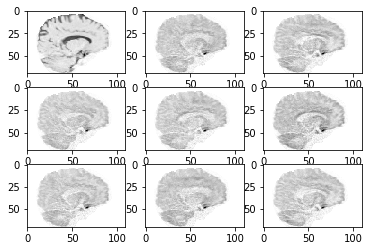

In [ ]:
for i in range(9):
    subplot(3, 3, i + 1)
    imshow(dwi_mask[60, :, :, i].T[::-1], 'binary')

## CT sensor coordinates

This is slightly different again because we don't need to mask anything, but apply two transforms to the coordinates of the sensors:

1. the affine transform of the CT scan itself (since sensors are provided as ijk coordinates)
2. the transfrom from CT to T1 spaces

Still, we start with a registration,

In [ ]:
# find files
t1_fn, = find(pid, 'anat', '*_T1w.nii')
ct_fn, = find(pid, 'anat', '*postimp_CT.nii')
sxyz_fn, = find(pid, 'ieeg', '*CT_electrodes.tsv')
# prep data
wd = f'epinov-data-xfer/{pid}/seeg'
os.path.exists(wd) or os.mkdir(wd)
# registration work files
aff_fn = f'{wd}/ct2t1.mat'
ct_in_t1_fn = f'{wd}/ct_in_t1.nii.gz'
# format images
ct_ras_ro_fn = ras_ro(ct_fn, wd=wd)
t1_ras_ro_fn = ras_ro(t1_fn, wd=wd)
# register images
eu.fsl('flirt',
       '-ref', t1_ras_ro_fn,
       '-in', ct_ras_ro_fn,
       '-omat', aff_fn,
       '-out', ct_in_t1_fn,
       '-cost', 'mutualinfo',
       '-dof', 12,
       '-searchrz', -180, 180,
       '-searchry', -180, 180,
       '-searchrx', -180, 180,
      )

['/soft/freesurfer-6/bin/mri_convert', '-rt', 'nearest', '--out_orientation', 'RAS', 'epinov/sub-4d5ab1139afc/ses-01/anat/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii', 'epinov-data-xfer/4d5ab1139afc/seeg/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii.ras.nii.gz']
mri_convert.bin -rt nearest --out_orientation RAS epinov/sub-4d5ab1139afc/ses-01/anat/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii epinov-data-xfer/4d5ab1139afc/seeg/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii.ras.nii.gz 
$Id: mri_convert.c,v 1.226 2016/02/26 16:15:24 mreuter Exp $
reading from epinov/sub-4d5ab1139afc/ses-01/anat/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, -0)
j_ras = (0, 1, -0)
k_ras = (-0, -0, 1)
Setting output orientation to RAS
writing to epinov-data-xfer/4d5ab1139afc/seeg/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii.ras.nii.gz...

['/soft/fsl/bin/fslreorient2std', 'epinov-data-xfer/4d5ab1139afc/seeg/sub-4d5ab1139afc_ses-01_acq-postimp_CT.nii.ras.nii.gz', '

In [ ]:
!cat $aff_fn

0.9811173274  -0.1102141378  -0.08490382983  -12.85949826  
0.08595248663  0.9695196498  -0.1943405078  10.65292542  
0.101764342  0.194950192  0.9630329783  5.755325914  
0  0  0  1  


Let's get the sEEG sensor coordinates & names

In [ ]:
seeg = np.genfromtxt(sxyz_fn, names=True, dtype=None, usecols=(0,1,2,3,4))
seeg_names = [_.decode('ascii') for _ in seeg['name']]
seeg_ijk = np.array([seeg[k] for k in 'xyz']).T

<ipython-input-171-85d538280b36>:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  seeg = np.genfromtxt(sxyz_fn, names=True, dtype=None, usecols=(0,1,2,3,4))


these coordinates are in voxels indices, so we need the affine transform to go to CT real space

In [ ]:
ct_aff = nibabel.load(ct_fn).affine
seeg_xyz = ct_aff.dot(np.c_[seeg_ijk, np.ones(len(seeg_ijk))].T)[:3].T

Now we can use another FSL utility to move coordinates from CT space to T1 space, according to the transform identified above,

In [ ]:
out = eu.fsl('img2imgcoord',
             '-mm',
             '-src', ct_ras_ro_fn,
             '-dest', ct_in_t1_fn,
             '-xfm', aff_fn,
              stdin='\n'.join(['%f %f %f' % tuple(_) for _ in seeg_xyz]))
t1_seeg_xyz = np.fromstring('\n'.join(out.strip().split('\n')[1:]), sep=' ').reshape((-1, 3))

Let's check this is correct,

In [ ]:
t1 = nibabel.load(t1_fn).get_fdata()
ct_in_t1 = nibabel.load(ct_in_t1_fn).get_fdata()
inv_aff = np.linalg.pinv(nibabel.load(ct_in_t1_fn).affine)

we should first check that the registration is ok,

<matplotlib.image.AxesImage>

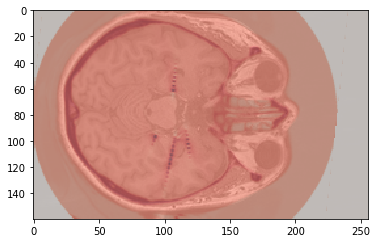

In [ ]:
slice = 123
imshow(t1[:, :, slice], 'gray', alpha=0.5)
imshow(ct_in_t1[..., slice], 'Reds', alpha=0.5)

and then zoom in on electrodes to check coordinates (which is easiest to visualize if we go to index coords ijk first)

In [ ]:
t1_seeg_ijk = inv_aff.dot(np.c_[t1_seeg_xyz, np.ones(len(t1_seeg_xyz))].T)[:3].T.astype('i')

and we visualize a few slices here:

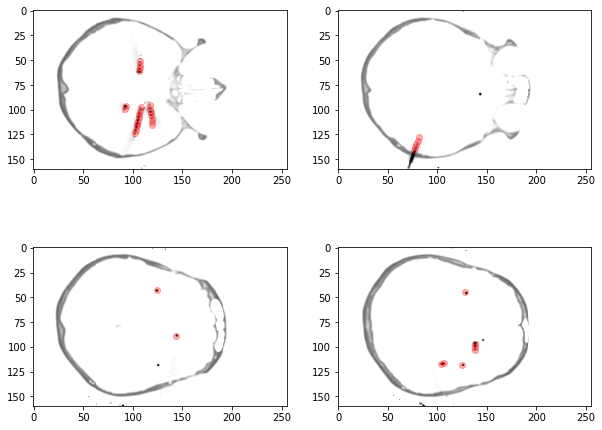

In [ ]:
figure(figsize=(10, 8))
for i, slice in enumerate([123, 130, 140, 150]):
    subplot(2, 2, i + 1)
    imshow(ct_in_t1[..., slice], 'binary', vmin=100)
    m = ((t1_seeg_ijk[:, 2] - slice)**2 < 4)
    plot(t1_seeg_ijk[m, 1], t1_seeg_ijk[m, 0], 'ro', alpha=0.3)

That looks fine, so we just write them to a file now,

In [ ]:
t1_seeg_fn = f'{wd}/t1_seeg.xyz'
with open(t1_seeg_fn, 'w') as fd:
    for name, (x, y, z) in zip(seeg_names, t1_seeg_xyz):
        fd.write('%s %f %f %f\n' % (name, x, y, z))

as a last step again we put all this into a function,

In [ ]:
def seeg_coords_to_t1(pid):
    # find files
    t1_fn, = find(pid, 'anat', '*_T1w.nii')
    ct_fn, = find(pid, 'anat', '*postimp_CT.nii')
    sxyz_fn, = find(pid, 'ieeg', '*CT_electrodes.tsv')
    # prep data
    wd = f'epinov-data-xfer/{pid}/seeg'
    os.path.exists(wd) or os.mkdir(wd)
    # registration work files
    aff_fn = f'{wd}/ct2t1.mat'
    ct_in_t1_fn = f'{wd}/ct_in_t1.nii.gz'
    # format images
    ct_ras_ro_fn = ras_ro(ct_fn, wd=wd)
    t1_ras_ro_fn = ras_ro(t1_fn, wd=wd)
    # register images
    eu.fsl('flirt',
           '-ref', t1_ras_ro_fn,
           '-in', ct_ras_ro_fn,
           '-omat', aff_fn,
           '-out', ct_in_t1_fn,
           '-cost', 'mutualinfo',
           '-dof', 12,
           '-searchrz', -180, 180,
           '-searchry', -180, 180,
           '-searchrx', -180, 180,
          )
    # load gardel output
    seeg = np.genfromtxt(sxyz_fn, names=True, dtype=None, usecols=(0,1,2,3,4))
    seeg_names = [_.decode('ascii') for _ in seeg['name']]
    seeg_ijk = np.array([seeg[k] for k in 'xyz']).T
    # move to real CT space
    ct_aff = nibabel.load(ct_fn).affine
    seeg_xyz = ct_aff.dot(np.c_[seeg_ijk, np.ones(len(seeg_ijk))].T)[:3].T
    # move to real T1 space
    out = eu.fsl('img2imgcoord',
             '-mm',
             '-src', ct_ras_ro_fn,
             '-dest', ct_in_t1_fn,
             '-xfm', aff_fn,
              stdin='\n'.join(['%f %f %f' % tuple(_) for _ in seeg_xyz]))
    t1_seeg_xyz = np.fromstring('\n'.join(out.strip().split('\n')[1:]), sep=' ').reshape((-1, 3))
    # write to file
    t1_seeg_fn = f'{wd}/t1_seeg.xyz'
    with open(t1_seeg_fn, 'w') as fd:
        for name, (x, y, z) in zip(seeg_names, t1_seeg_xyz):
            fd.write('%s %f %f %f\n' % (name, x, y, z))

and check on different pid

In [ ]:
seeg_coords_to_t1('0ea47a652d48')

<ipython-input-267-5f910c902453>:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  seeg = np.genfromtxt(sxyz_fn, names=True, dtype=None, usecols=(0,1,2,3,4))


In [ ]:
!ls epinov-data-xfer/0ea47a652d48/seeg

ct2t1.mat
ct_in_t1.nii.gz
sub-0ea47a652d48_ses-01_acq-postimp_CT.nii.ras.nii.gz
sub-0ea47a652d48_ses-01_acq-postimp_CT.nii.ras.ro.nii.gz
sub-0ea47a652d48_ses-01_acq-preop_T1w.nii.ras.nii.gz
sub-0ea47a652d48_ses-01_acq-preop_T1w.nii.ras.ro.nii.gz
t1_seeg.xyz


## Seizure time series

The VHDR format files should be converted to FIF format which is quick compared to previous steps:

In [ ]:
import mne

def convert_vhdrs(pid):
    vhdrs = find(pid, 'ieeg', '*.vhdr')
    wd = f'epinov-data-xfer/{pid}/seeg'
    os.path.exists(wd) or os.mkdir(wd)
    for vhdr in vhdrs:
        raw = mne.io.read_raw_brainvision(vhdr)
        fif_fn = vhdr.replace('.vhdr', '-raw.fif')
        raw.save(fif_fn)

## Run it all

In [ ]:
from concurrent.futures import ThreadPoolExecutor

jobs = []
with ThreadPoolExecutor(max_workers=28) as exe:
    for pid in pid_ok:
        run = lambda f: jobs.append(exe.submit(f, pid))
        wd = f'epinov-data-xfer/{pid}/seeg'
        os.path.exists(wd) or os.mkdir(wd)
        run(mask_original)
        run(mask_original_dwi)
        run(convert_vhdrs)
        run(seeg_coords_to_t1)

Extracting parameters from epinov/sub-acda1a7a0c9c/ses-01/ieeg/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type1_run-01_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-rest_run-01_ieeg.vhdr...
Extracting parameters from epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-rest_run-01_ieeg.vhdr...
Extracting parameters from epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-01_ieeg.vhdr...
Setting channel info structure...
Setting channel info structure...
Setting channel info structure...
Writing /home/duke/epinov/sub-acda1a7a0c9c/ses-01/ieeg/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif
Writing /home/duke/epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif
Writing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-rest_run-01_ieeg-raw.fif
Writing /home/duk

<ipython-input-276-00cd2044e2dd>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr)
<ipython-input-276-00cd2044e2dd>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr)


Closing /home/duke/epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-02_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-02_ieeg-raw.fif
Closing /home/duke/epinov/sub-acda1a7a0c9c/ses-01/ieeg/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-acda1a7a0c9c/ses-01/ieeg/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type2_run-01_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-acda1a7a0c9c/ses-01/ieeg/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type2_run-01_ieeg-raw.fif
Closing /home/duke/epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-02_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-d48

<ipython-input-276-00cd2044e2dd>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr)


Closing /home/duke/epinov/sub-d480db186d19/ses-01/ieeg/sub-d480db186d19_ses-01_task-seizure_acq-type1_run-04_ieeg-raw.fif [done]
Closing /home/duke/epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-seizure_acq-type1_run-02_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-seizure_acq-type1_run-02_ieeg-raw.fif
Closing /home/duke/epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-seizure_acq-type1_run-02_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-sleep_run-01_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-3842a81ac98b/ses-01/ieeg/sub-3842a81ac98b_ses-01_task-sleep_run-01_ieeg-raw.fif


<ipython-input-276-00cd2044e2dd>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr)


Closing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-rest_run-01_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type1_run-01_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif
Closing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type1_run-02_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type1_run-02_ieeg-raw.fif
Closing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type1_run-02_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-56d98746ac85/ses

<ipython-input-276-00cd2044e2dd>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr)


Closing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-seizure_acq-type2_run-02_ieeg-raw.fif [done]
Extracting parameters from epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-sleep_run-01_ieeg.vhdr...
Setting channel info structure...
Writing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-sleep_run-01_ieeg-raw.fif


<ipython-input-276-00cd2044e2dd>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(vhdr)


Closing /home/duke/epinov/sub-56d98746ac85/ses-01/ieeg/sub-56d98746ac85_ses-01_task-sleep_run-01_ieeg-raw.fif [done]


<ipython-input-267-5f910c902453>:28: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  seeg = np.genfromtxt(sxyz_fn, names=True, dtype=None, usecols=(0,1,2,3,4))


## Zip

In [ ]:
import shutil, glob

In [ ]:
!ls epinov-data-xfer/3842a81ac98b/report\ 3842a81ac98b.pdf

epinov-data-xfer/3842a81ac98b/report 3842a81ac98b.pdf


In [ ]:
zip_contents = 'epinov-data-xfer/ready'
os.path.exists(zip_contents) or os.mkdir(zip_contents)
for pid in pid_ok:
    dst = f'{zip_contents}/{pid}'
    os.path.exists(dst) or os.mkdir(dst)
    shutil.copy(f'epinov-data-xfer/{pid}/mri/mask_orig.nii.gz',
                f'{dst}/T1.nii.gz')
    shutil.copy(f'epinov-data-xfer/{pid}/dwi-AP/mask_orig.nii.gz',
                f'{dst}/DWI_AP.nii.gz')
    bvec, = find(pid, 'dwi', '*AP*bvec*')
    bval, = find(pid, 'dwi', '*AP*bval*')
    shutil.copy(bvec, f'{dst}/AP_bvec')
    shutil.copy(bval, f'{dst}/AP_bval')
    try:
        shutil.copy(f'epinov-data-xfer/{pid}/dwi-PA/mask_orig.nii.gz',
                    f'{dst}/DWI_PA.nii.gz')
        bvec, = find(pid, 'dwi', '*PA*bvec*')
        bval, = find(pid, 'dwi', '*PA*bval*')
        shutil.copy(bvec, f'{dst}/PA_bvec')
        shutil.copy(bval, f'{dst}/PA_bval')
    except Exception as e:
        print('no PA for', pid, e)
    shutil.copy(f'epinov-data-xfer/{pid}/seeg/t1_seeg.xyz',
                f'{dst}/t1_seeg_pos.xyz')
    for fif in glob.glob(f'epinov/sub-{pid}/ses-01/ieeg/*-raw.fif'):
        shutil.copy(fif, f'{dst}/{os.path.basename(fif)}')
    shutil.copy(f'epinov-data-xfer/{pid}/report {pid}.pdf',
                f'{dst}/report.pdf')

no PA for acda1a7a0c9c [Errno 2] No such file or directory: 'epinov-data-xfer/acda1a7a0c9c/dwi-PA/mask_orig.nii.gz'


In [ ]:
!zip -h

Copyright (c) 1990-2008 Info-ZIP - Type 'zip "-L"' for software license.
Zip 3.0 (July 5th 2008). Usage:
zip [-options] [-b path] [-t mmddyyyy] [-n suffixes] [zipfile list] [-xi list]
  The default action is to add or replace zipfile entries from list, which
  can include the special name - to compress standard input.
  If zipfile and list are omitted, zip compresses stdin to stdout.
  -f   freshen: only changed files  -u   update: only changed or new files
  -d   delete entries in zipfile    -m   move into zipfile (delete OS files)
  -r   recurse into directories     -j   junk (don't record) directory names
  -0   store only                   -l   convert LF to CR LF (-ll CR LF to LF)
  -1   compress faster              -9   compress better
  -q   quiet operation              -v   verbose operation/print version info
  -c   add one-line comments        -z   add zipfile comment
  -@   read names from stdin        -o   make zipfile as old as latest entry
  -x   exclude the following nam

In [ ]:
!rm -rf epinov-data-xfer/epinov-first-4
!mv epinov-data-xfer/ready epinov-data-xfer/epinov-first-4

In [ ]:
!cd epinov-data-xfer && rm -fv *.zip && zip -r -9 epinov-first-4.zip epinov-first-4

removed ‘epinov-first-4.zip’
  adding: epinov-first-4/ (stored 0%)
  adding: epinov-first-4/acda1a7a0c9c/ (stored 0%)
  adding: epinov-first-4/acda1a7a0c9c/T1.nii.gz (deflated 11%)
  adding: epinov-first-4/acda1a7a0c9c/DWI_AP.nii.gz (deflated 6%)
  adding: epinov-first-4/acda1a7a0c9c/AP_bvec (deflated 58%)
  adding: epinov-first-4/acda1a7a0c9c/AP_bval (deflated 96%)
  adding: epinov-first-4/acda1a7a0c9c/t1_seeg_pos.xyz (deflated 57%)
  adding: epinov-first-4/acda1a7a0c9c/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type1_run-01_ieeg-raw.fif (deflated 43%)
  adding: epinov-first-4/acda1a7a0c9c/sub-acda1a7a0c9c_ses-01_task-seizure_acq-type2_run-01_ieeg-raw.fif (deflated 45%)
  adding: epinov-first-4/acda1a7a0c9c/sub-acda1a7a0c9c_ses-01_task-sleep_run-01_ieeg-raw.fif (deflated 46%)
  adding: epinov-first-4/acda1a7a0c9c/report.pdf (deflated 42%)
  adding: epinov-first-4/56d98746ac85/ (stored 0%)
  adding: epinov-first-4/56d98746ac85/T1.nii.gz (deflated 14%)
  adding: epinov-first-4/56d98746ac8

`-9` takes too long, let's stick with `-0`

In [ ]:
!ls -lh epinov-data-xfer/*.zip

-rw-r--r-- 1 duke bdi 8.5G Apr  2  2020 epinov-data-xfer/epinov-first-4.zip


In [ ]:
!cd epinov-data-xfer/ && split --bytes=1G epinov-first-4.zip epinov-first-4.zip

In [ ]:
!ls -lh epinov-data-xfer/x*

-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xaa
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xab
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xac
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xad
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xae
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xaf
-rw-r--r-- 1 duke bdi 1.0G Apr  3 00:00 epinov-data-xfer/xag
-rw-r--r-- 1 duke bdi 1.0G Apr  3 00:00 epinov-data-xfer/xah
-rw-r--r-- 1 duke bdi 494M Apr  3 00:00 epinov-data-xfer/xai


In [ ]:
%%bash
for f in epinov-data-xfer/x*
do
    openssl smime -encrypt -binary -aes-256-cbc -in $f -out $f.enc -outform DER INS3DS.certificate.pem &
done
wait

In [ ]:
!ls -lh epinov-data-xfer/x*

-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xaa
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xaa.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xab
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xab.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xac
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xac.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xad
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xad.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xae
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xae.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  2 23:59 epinov-data-xfer/xaf
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xaf.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  3 00:00 epinov-data-xfer/xag
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/xag.enc
-rw-r--r-- 1 duke bdi 1.0G Apr  3 00:00 epinov-data-xfer/xah
-rw-r--r-- 1 duke bdi 1.1G Apr  3 00:03 epinov-data-xfer/

In [ ]:
!sha256sum epinov-data-xfer/x*.enc

450c76e4373c837f45b6041865a148a8d53b42492ceced19417a907d5ef8d541  epinov-data-xfer/xaa.enc
6cafbb6e189984e44eb7084cc506676d4d91006be9be1ff47d1e63dc9f546b86  epinov-data-xfer/xab.enc
2f6d8121282922e8e277576c9d4e060e0725a33b4a93e2671c61b95ea7009d4f  epinov-data-xfer/xac.enc
e4abdd887a296da202e93fe8444f6cf706b24b2441f083d40568dad4e8f6070a  epinov-data-xfer/xad.enc
744d106d1f30a6b1c4ed0b1b5c21c5e70a573f1ced4043772ca8eaddb5ab4f4f  epinov-data-xfer/xae.enc
57c3616353dc7a3794b3e8baebee231719fa35857f78b58cd2f1f226dd46c093  epinov-data-xfer/xaf.enc
c1ca4dd2a7a7b64cf4aa7c931e5a1fda3d63eb5a248f0503d4690445492ccb03  epinov-data-xfer/xag.enc
5f646819bc0c4b58bf0416de829d433c27ab4a926eb50506171f57d83fdadf3b  epinov-data-xfer/xah.enc
a1521124af46b1825a03414cc0b21138ccf388a2702f035b39e89ad52272d694  epinov-data-xfer/xai.enc
